В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os

from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ML_Course/HM/kaggle_competition_1

/content/drive/MyDrive/ML_Course/HM/kaggle_competition_1


In [4]:
from process_bank_churn import preprocess_data, preprocess_new_data, compute_auroc_and_build_roc

In [5]:
df = pd.read_csv("/content/drive/MyDrive/ML_Course/Data/churn_prediction/train.csv", index_col=0)

In [6]:
input_cols = list(df.columns)[2:-1]
target_col = 'Exited'

In [7]:
data = preprocess_data(df, input_cols, target_col)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [8]:
X_train = data['train_X']
train_targets = data['train_y']
X_val = data['val_X']
val_targets = data['val_y']

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [9]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)

KNeighborsClassifier()

AUROC for Train: 0.96


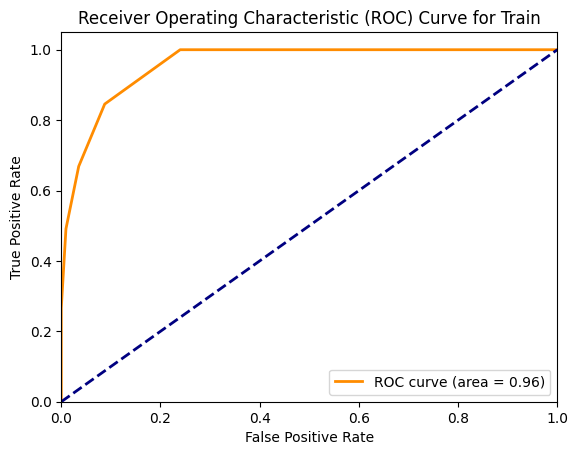

0.9588658166812591

In [10]:
compute_auroc_and_build_roc(knn, X_train, train_targets, 'Train')

AUROC for Validation: 0.87


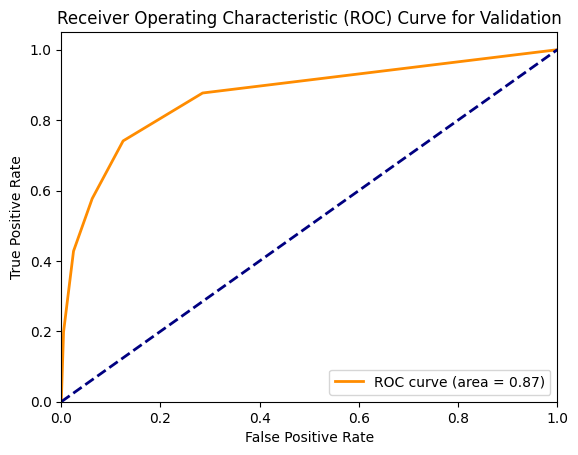

0.8675008573976267

In [11]:
compute_auroc_and_build_roc(knn, X_val, val_targets, 'Validation')

Модель демонструє високе значення AUROC на валідаційних даних але зважаючи на велику різницю між результатами на тестовому та валідаційному наборах, маємо перенавчання моделі.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [12]:
knn = KNeighborsClassifier()
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [13]:
print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 9} 0.8719166666666667


In [14]:
knn_best = knn_gs.best_estimator_

AUROC for Train: 0.94


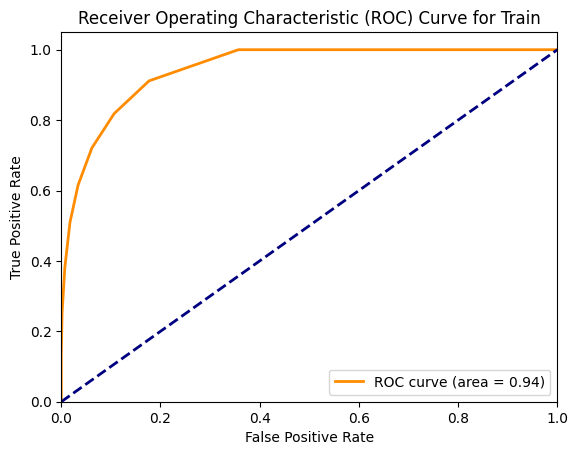

0.9449711224664143

In [15]:
compute_auroc_and_build_roc(knn_best, X_train, train_targets, 'Train')

AUROC for Validation: 0.88


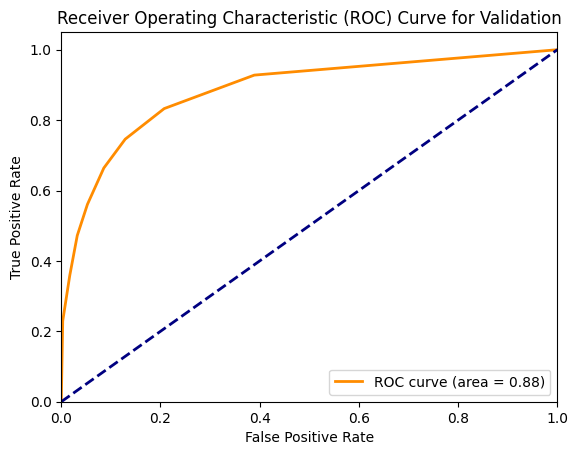

0.8827886000411551

In [16]:
compute_auroc_and_build_roc(knn_best, X_val, val_targets, 'Validation')

Модель стала трохи кращою, проте все одно демонтрує явний оверфіт.  
Модель, натренована на алгоритмі дерева прийняття рішень в попередньому домашньому завданні краща за цю, оскільки при підібраному оптимальному значенні max_depth=5 показала краще значення AUROC на валідаційних даних (0.9219) при цьому були відсутні ознаки перенавчання, оскільки AUROC на тренувальних даних значно не відрізнялась від валідаційних (0.9256)

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [17]:
%%time
dt = DecisionTreeClassifier(random_state=42)
params_dt = {'max_depth': np.arange(1, 20, 2), 'max_leaf_nodes': np.arange(2, 10)}
dt_gs = GridSearchCV(dt, params_dt, scoring='roc_auc', cv=3)
dt_gs.fit(X_train, train_targets)

CPU times: user 5.56 s, sys: 14.9 ms, total: 5.57 s
Wall time: 5.68 s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [18]:
print(dt_gs.best_params_, dt_gs.best_score_)

{'max_depth': 5, 'max_leaf_nodes': 9} 0.8990230600400091


In [19]:
dt_best = dt_gs.best_estimator_

AUROC for Train: 0.90


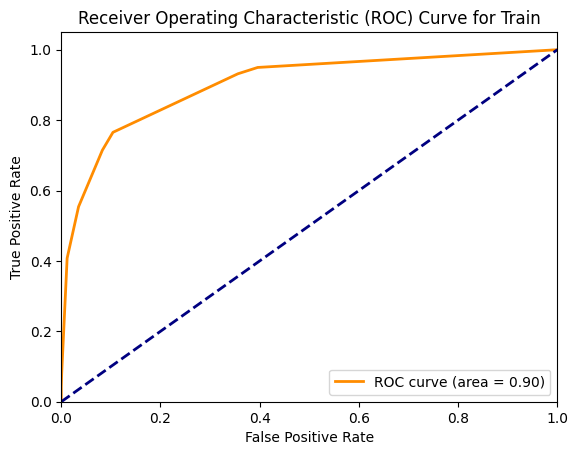

0.9001138615074584

In [20]:
compute_auroc_and_build_roc(dt_best, X_train, train_targets, 'Train')

AUROC for Validation: 0.90


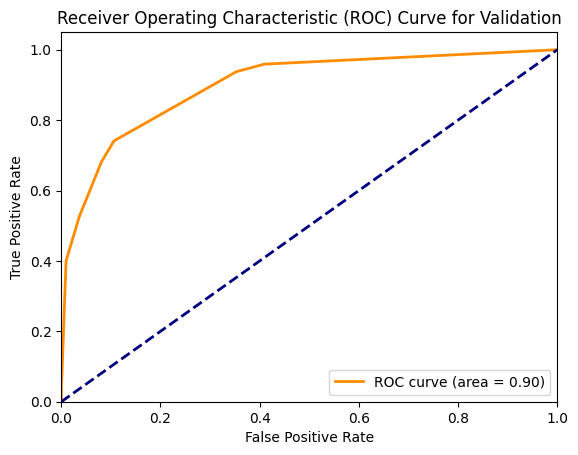

0.898395980519926

In [21]:
compute_auroc_and_build_roc(dt_best, X_val, val_targets, 'Validation')

Модель виглядає не погано, оверфіту немає. Проте, модель з попереднього домашнього завдання, для якої я вручну підбирала гіперпараметри, показала краще значення AUROC на обох даних (0.9256 та 0.9219 для трейн та вал наборів відповідно, з параметрами max_depth=5, max_leaf_nodes=40)

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [22]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [23]:
%%time
dt_random = DecisionTreeClassifier(random_state=42)
dt_random_gs = RandomizedSearchCV(dt_random, params_dt, n_iter=40, scoring='roc_auc', cv=3, random_state=42)
dt_random_gs.fit(X_train, train_targets)

CPU times: user 1.66 s, sys: 10.7 ms, total: 1.67 s
Wall time: 2.18 s


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [24]:
print(dt_random_gs.best_params_, dt_random_gs.best_score_)

{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'} 0.910864318350194


In [25]:
dt_random_search_best = dt_random_gs.best_estimator_

AUROC for Train: 0.92


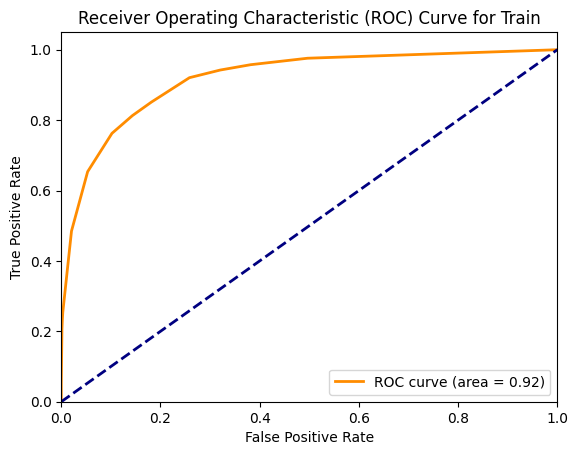

0.9169275635848141

In [26]:
compute_auroc_and_build_roc(dt_random_search_best, X_train, train_targets, 'Train')

AUROC for Validation: 0.92


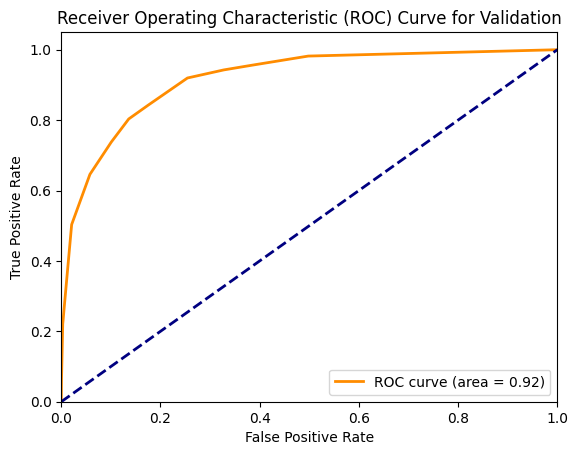

0.9166204815145071

In [27]:
compute_auroc_and_build_roc(dt_random_search_best, X_val, val_targets, 'Validation')

Модель показала дуже гарні результати як з точки зору auroc, так і з точки зору генералізації. Вона краща за попередньо навчену млдель з GridSearch

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [28]:
test_raw_df = pd.read_csv("/content/drive/MyDrive/ML_Course/Data/churn_prediction/test.csv", index_col=0)

In [30]:
scaler = data['scaler']
encoders = data['encoders']

In [31]:
test_inputs = preprocess_new_data(test_raw_df, scaler, encoders, input_cols)

/content/drive/MyDrive/ML_Course/HM/kaggle_competition_1/process_bank_churn.py:181: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])
/content/drive/MyDrive/ML_Course/HM/kaggle_competition_1/process_bank_churn.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inputs[f"Encoded_{col}"] = encoder.transform(test_inputs[[col]])
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-v

In [33]:
test_inputs['Exited'] = dt_random_search_best.predict_proba(test_inputs)[:, 1]
sample_submission = pd.read_csv("/content/drive/MyDrive/ML_Course/Data/churn_prediction/sample_submission.csv", index_col=0)
sample_submission['Exited'] = test_inputs['Exited'].values
sample_submission.head(5)

,Exited
id,
15000,0.237911
15001,0.012115
15002,0.203947
15003,0.569848
15004,0.082171


In [34]:
sample_submission.reset_index().to_csv("/content/drive/MyDrive/ML_Course/Data/churn_prediction/submission_dt_random_search_best.csv", index=False)